In [10]:
import numpy as np
from PIL import Image
import random
from scipy import ndarray, ndimage
import skimage.io as io
import skimage as sk
from skimage import transform
from skimage import util
import cv2
import shutil
import os
import json
from PIL import ImageDraw
from IPython.display import display
import glob
import time
import threading
import traceback
import matplotlib.pyplot as plt
import copy


def rotate(image_array: ndarray, angle):
    return ndimage.rotate(image_array, angle, reshape=True, order=0)


def brightness(img, brightness):
    return sk.exposure.adjust_gamma(img, brightness).astype(np.uint8)

def make_mask(xy,size):
  '''
  Description:
    polygon : [(x1,y1), (x2,y2)]
    size : size of the image (width,height)

    return : PIL image (mask)
  '''
  mask = Image.new('RGB',size)
  img1 = ImageDraw.Draw(mask)   
  img1.polygon(xy,fill = '#FF0000')  
  return mask

def get_polygons_from_mask(mask):
  '''
  This funtion will return you polygons from a binary maskj
  '''
  border = cv2.copyMakeBorder(np.asarray(mask,np.uint8), 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0 )
  border = cv2.cvtColor(border, cv2.COLOR_RGB2GRAY)
  polygons= cv2.findContours(border, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  polygons = polygons[0] if len(polygons) == 2 else polygons[1]
  polygons = [polygon.flatten() for polygon in polygons]
  polygons =[tuple((list(i))) for i in  [
          np.array(point).reshape(-1, 2).round().astype(int)
          for point in polygons
      ][0]]
  return polygons


def draw_labels(img_path, polygons): #For debugging
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    for polygon in polygons:
        polygon = polygons[polygon]
        polygon = [ int(_) for _ in polygon]
        draw.polygon( polygon , outline="red")
    return img

def merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 







def parse_via_json(json_file_path, images_dir_path):
#     labels = !cat ${json_file_path}
#     labels = json.loads(labels[0])['_via_img_metadata']
    labels = json.load(open(json_file_path))['_via_img_metadata']
    
    keys = list(labels.keys())
    
    images = dict()
    for key in keys:
        regions = labels[key]["regions"]
        image_name = labels[key]['filename']

        annotations = dict()
        for region in regions:
            try:
                x = region['shape_attributes']['all_points_x']
                y = region['shape_attributes']['all_points_y']
                
                region_name = list(region['region_attributes']['class'].keys())[0]
                region_name = region_name
                region_name = region_name
                annotations[region_name] = list(zip(x,y))
                
            except:
                traceback.print_exc()
                pass
            
        images[images_dir_path + image_name] = annotations
                
    return images

class Augmentation:
    
    def __init__(self, DIR_PATH):
        from multiprocessing.pool import ThreadPool
        self.pool = ThreadPool(128)
        self.augmented_images = dict()
        self.is_processing = False
        self.pending = 0
        self.DIR_PATH = DIR_PATH
        shutil.rmtree(self.DIR_PATH, True)
        if not os.path.exists(self.DIR_PATH):
            os.makedirs(self.DIR_PATH, mode=0o777)

        
        
    def __del__(self):
        self.pool.close()
        self.pool.join()

        
    def callback(self, response):
        aug_image_name, response = response[0]
        if aug_image_name:
            self.augmented_images[aug_image_name] = response
        self.pending -= 1
        
    def err(self, error):
        print("Error", error)
        traceback.print_exc()
        
        
    def run(self, img_path, labels):

        try:

            img = sk.io.imread(img_path)[:,:,:3]
            w,h = img.shape[1], img.shape[0]

            print(labels)
            coordinates = list(labels.values())[0]


            for angle in range(0, 360, 100):
                self.pending += 1
                sharpness  = random.randint(100, 200)/100.0
                aug_image_name = "{3}-{2}-{0}-{1}.jpg".format(angle, sharpness, random.randint(1111111,9999999), img_path.split("/")[-1])
                save_path = self.DIR_PATH + aug_image_name            
                self.r = self.pool.map_async(self.augment_image, [(img, coordinates, w, h, angle, sharpness, save_path, labels )], callback=self.callback, error_callback=self.err)
                # aug_image_name,response = self.augment_image((img, coordinates, w, h, angle, sharpness, save_path, labels ))

                # self.augmented_images[aug_image_name] = response
        except:
            pass
        
    def augment_image(self, args):
        pil_image, coordinates, width, height, angle, sharpness, save_path, labels = args

        cx, cy = width//2, height//2
        pil_image = Image.fromarray(pil_image)
        size = pil_image.size
        mask = make_mask(coordinates,size)
        
        augmented = pil_image.rotate(angle)
        augmented_mask = mask.rotate(angle)
        
        
        sharpness = random.randint(100, 200)/100.0

        augmented = Image.fromarray(brightness(np.asarray(augmented), sharpness))
        coordinates = [list(map(int,list(i))) for i in zip(*get_polygons_from_mask(augmented_mask))]
        
        response = None
        if coordinates is not None:
            augmented.save(save_path)
            response  = {list(labels.keys())[0] : coordinates}
            aug_image_name = save_path.split("/")[-1]            
            return (aug_image_name, copy.deepcopy(response))
        else:
            return (False, False)



def save_mrcnn_labels(augmented_images,json_file_path ,classes):
    existing_data = dict()
    
    
    mrcnn_data = dict()
    a1 = augmented_images
    for augmented_image in a1:
      
      parts = augmented_image.split(".")
      image_name, extension = ".".join(parts[:-1]), parts[-1]
      key = image_name + ".json"
      mrcnn_data[key] = dict()
      mrcnn_data[key]['filename'] = image_name
      mrcnn_data[key]['file_attributes'] = dict()
      mrcnn_data[key]['regions'] = []
      for label in a1[augmented_image]:
          region = dict()
          region["region_attributes"] = dict({"class": classes.index(label) + 1})
          region["shape_attributes"] = dict()
          region["shape_attributes"]["name"] = "polygon"
          region["shape_attributes"]["all_points_x"] = a1[augmented_image][label][0]
          region["shape_attributes"]["all_points_y"] = a1[augmented_image][label][1]
          mrcnn_data[key]['regions'] += [ region  ]
    
    
    with open(json_file_path, 'w') as f:
        json.dump(mrcnn_data, f)

In [11]:
DIR_PATH = "/media/sohaib/additional_/DataScience/fashion_detection/clothes/"
doc_labels = "/media/sohaib/additional_/DataScience/fashion_detection/clothes/via_project_23Aug2021_1h53m_check.json"

# doc_labels = "/additional_drive/all_docs_training/training_model/us_florida_driving_license_h_type1/us_florida_driving_license_h_type1.json"
#DIR_PATH = str("/".join(doc_labels.split("/")[0:-1])+"/")

# import multiprocessing
from time import sleep

images = parse_via_json(doc_labels, DIR_PATH)
#     Denmark_passport.json
    
classes = list(set([ __ for _ in images.values() for __ in list(_.keys())]))
print(classes)

if len(images) <= 1:
    print("I need at least 2 images")
    exit()

total_training = int(len(images) * 0.9)
counter = 0
train = Augmentation(DIR_PATH + "/train/")
val = Augmentation(DIR_PATH + "/val/")

print("Creating Images....")
for image_path in images:
  if  counter < total_training:

      train.run(image_path, images[image_path])
  else:
      val.run(image_path, images[image_path])
  counter += 1
  

while train.pending > 0 or val.pending > 0:
    print("Train Pending",train.pending)
    print("Validation Pending",val.pending)
    sleep(1)


train.augmented_images


print("Images created. Now saving labels....")
save_mrcnn_labels(train.augmented_images, DIR_PATH + "/train/via_region_data.json", classes)
save_mrcnn_labels(val.augmented_images, DIR_PATH + "/val/via_region_data.json", classes)
print("================================================================================================================")
print("Following are the class names used in this dataset. You need to pass these to MRCNN prediction script/notebook")
print("================================================================================================================")
print("\n")
print('"' + '","'.join(classes) + '"')
file1 = open(DIR_PATH+"labels.txt","w")
write='"' + '","'.join(classes) + '"'
file1.writelines(write)
file1.close()


['v_neck', 'square_neck', 'collar_neck', 'round_neck']
Creating Images....
{'round_neck': [(236, 273), (296, 354), (443, 347), (453, 294), (407, 233), (266, 223)]}
{'round_neck': [(234, 304), (223, 404), (512, 395), (504, 293), (425, 231), (243, 246)]}
{'round_neck': [(265, 257), (232, 313), (340, 382), (528, 337), (503, 252), (272, 232)]}
{'round_neck': [(271, 307), (252, 384), (484, 388), (491, 248), (285, 271)]}
{'round_neck': [(215, 229), (180, 316), (252, 362), (408, 348), (450, 221)]}
{'round_neck': [(272, 262), (247, 370), (549, 356), (515, 177), (271, 238)]}
{'round_neck': [(191, 166), (137, 330), (288, 437), (593, 434), (636, 221), (610, 160), (216, 153)]}
{'round_neck': [(275, 227), (236, 328), (403, 368), (536, 315), (505, 197)]}
{'round_neck': [(273, 161), (244, 245), (403, 245), (449, 149), (410, 133)]}
{'round_neck': [(239, 235), (208, 327), (375, 371), (497, 275), (471, 213)]}
{'round_neck': [(257, 236), (226, 352), (445, 371), (531, 258), (483, 204)]}
{'round_neck': [(2

# Validation of Augmentation

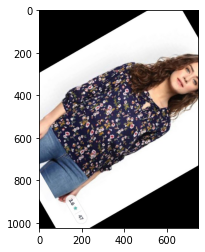

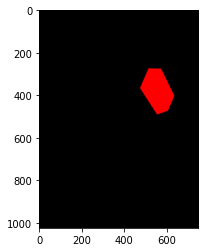

In [23]:

base_path = '/media/sohaib/additional_/DataScience/fashion_detection/clothes/train/'
json_file_path = "/media/sohaib/additional_/DataScience/fashion_detection/clothes/train/via_region_data.json"
image_name = "WhatsApp Image 2021-08-22 at 5.53.50 PM (1).jpeg-7166641-300-1.46"


labels = json.load(open(json_file_path))
x = labels[f'{image_name}.json']['regions'][0]['shape_attributes']['all_points_x']
y = labels[f'{image_name}.json']['regions'][0]['shape_attributes']['all_points_y']


img = Image.open(f'{base_path}{image_name}.jpg')
mask = make_mask(list(zip(x,y)),img.size)

plt.imshow(img)
plt.show()
plt.imshow(mask)
plt.show()


In [ ]:
polygons = [(356, 467), (356, 468), (355, 469), (355, 471), (354, 472), (354, 474), (353, 475), (353, 477), (352, 478), (352, 481), (351, 482), (351, 484), (350, 485), (350, 487), (349, 488), (349, 490), (348, 491), (348, 493), (347, 494), (347, 496), (346, 497), (346, 499), (345, 500), (345, 502), (344, 503), (344, 505), (343, 506), (343, 509), (342, 510), (342, 512), (341, 513), (341, 515), (340, 516), (340, 518), (339, 519), (339, 521), (338, 522), (338, 523), (339, 523), (340, 524), (341, 524), (342, 525), (343, 525), (344, 526), (345, 526), (346, 527), (347, 527), (348, 528), (349, 528), (350, 529), (351, 529), (352, 530), (353, 530), (354, 531), (355, 531), (356, 532), (357, 532), (358, 533), (359, 533), (360, 534), (361, 534), (362, 535), (364, 535), (365, 536), (366, 536), (367, 537), (368, 537), (369, 538), (370, 538), (371, 539), (372, 539), (373, 540), (374, 540), (375, 541), (376, 541), (377, 542), (378, 542), (379, 543), (380, 543), (381, 544), (382, 544), (383, 545), (384, 545), (385, 546), (386, 546), (387, 547), (388, 547), (389, 548), (655, 548), (658, 545), (659, 545), (663, 541), (664, 541), (669, 536), (670, 536), (675, 531), (676, 531), (680, 527), (681, 527), (683, 525), (683, 524), (682, 523), (682, 522), (681, 521), (681, 520), (680, 519), (680, 517), (679, 516), (679, 515), (678, 514), (678, 513), (677, 512), (677, 511), (676, 510), (676, 508), (675, 507), (675, 506), (674, 505), (674, 504), (673, 503), (673, 501), (672, 500), (672, 499), (671, 498), (671, 497), (670, 496), (670, 494), (669, 493), (669, 492), (668, 491), (668, 490), (667, 489), (667, 487), (666, 486), (666, 485), (665, 484), (665, 483), (664, 482), (664, 481), (663, 480), (663, 478), (662, 477), (662, 476), (661, 475), (661, 474), (660, 473), (660, 472), (600, 472), (599, 471), (539, 471), (538, 470), (479, 470), (478, 469), (418, 469), (417, 468), (357, 468)]


In [ ]:
base_path = '/content/drive/My Drive/unet/images/train/'
img_name = list(d.keys())[0]
print(img_name)

polygons = [d[img_name]['regions'][0]['shape_attributes']['all_points_x'], d[img_name]['regions'][0]['shape_attributes']['all_points_y']] 
print(polygons)

def draw_labels(img_path, polygons): #For debugging
    img = Image.open(img_path).convert("RGB")
    plt.show(img)
    plt.show()
    
    return make_mask(polygons,img.size)


img = draw_labels(f'{base_path}{img_name}'.replace(".json",'.jpg'), list(zip(polygons[0],polygons[1])))
display(img)